In [ ]:
Pipe line para proceso

In [2]:
# Librerias a utilizar, por defecto ya vienen instaladas en el entorno "pip install git jupyterlab numpy pandas plotly "
# para mejor visualizacion de los df y manejo de estadisticas:
# ! pip install pandasgui
# ! pip install pandas-profiling
# ! pip install seaborn
# ! pip install scipy
#! pip install optbinning
#! pip install ortools == 9.4.1874
#! pip install -U scikit-learn
import os
import datetime
from IPython.display import clear_output
import pandas as pd
import numpy as np
from pandasgui import show
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
import statsmodels.api as sm
from optbinning import OptimalBinning
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
print("librerias cargadas correctamente") 

librerias cargadas correctamente


In [ ]:
class CargadorCSV:
    """Clase para carga de archivos con formato .csv"""
    def __init__(self, file_path):
        """
        Constructor de la clase. Recibe la ruta del archivo.
        """
        self.file_path = file_path
    
    def visualizar_avance(self, bytes_avance, bytes_completo):
        """Visualiza el avance de la carga del archivo en porcentaje."""
        avance = min(round(bytes_avance / bytes_completo, 2) * 100, 100)
        clear_output(wait=True)
        print(f"Avance estimado: {avance}%")
    
    def crear_csv_por_horarios(self, chunk_size=100000, sep="|"):
        """Crea archivos CSV separados por horarios a partir del archivo original."""
        try:
            bytes_completo = os.path.getsize(self.file_path)
            encabezado = True
            horarios = ['MEDIODIA', 'TARDE', 'NOCHE', 'MANANA']
            
            for chunk in pd.read_csv(self.file_path, sep=sep, chunksize=chunk_size):
                bytes_avance = 0
                
                if encabezado:
                    for clasificador_horario in horarios:
                        df_filtered = chunk.loc[chunk["HORARIO"] == clasificador_horario].drop("HORARIO", axis=1)
                        file_name = f"{self.file_path[:-4]}_{clasificador_horario}.csv"
                        df_filtered.to_csv(file_name, index=False)
                        bytes_avance += os.path.getsize(file_name)
                    df_Nofiltered = chunk.loc[~chunk["HORARIO"].isin(horarios)]
                    df_Nofiltered.to_csv(f"{self.file_path[:-4]}_ValoresPerdidos.csv ", index=False)
                    
            #df_MANANA_filtered = df_MANANA.loc[~df_MANANA["MES"].isin(months_to_exclude)]
                    encabezado = False
                else:
                    for clasificador_horario in horarios:
                        df_filtered = chunk.loc[chunk["HORARIO"] == clasificador_horario].drop("HORARIO", axis=1)
                        file_name = f"{self.file_path[:-4]}_{clasificador_horario}.csv"
                        df_filtered.to_csv(file_name, mode='a', index=False, header=False)
                        bytes_avance += os.path.getsize(file_name)
                    df_Nofiltered = chunk.loc[~chunk["HORARIO"].isin(horarios)]
                    df_Nofiltered.to_csv(f"{self.file_path[:-4]}_ValoresPerdidos.csv ",mode = 'a', index=False, header=False)                   
                
                self.visualizar_avance(bytes_avance, bytes_completo)
            #clear_output(wait=True)
            print(f"Proceso terminado")
        except Exception as error:
            print("Ocurrió un error:", error)

In [ ]:
cargador = CargadorCSV("..\\datos_internos\\20210513_Challenge_AA.csv") 
cargador.crear_csv_por_horarios()

In [3]:
class revisor_data_csv:
    """Clase para carga y revisión de archivos con formato .csv
    Con esto podemos crear agregar diferentes métodos en función de lo que queramos visualizar"""
    def __init__(self, file_path):
        """
        Constructor de la clase que recibe la ruta del archivo y carga el archivo
        Se asume archivos .csv estándar, sep = ","
        """
        self.file_path = file_path
        self.matriz_correlacion = None
        try:
            # Se carga el df y se crea un df para registrar cambios
            self.mensaje("cargando", self.file_path)
            self.df = pd.read_csv(self.file_path)
            self.mensaje("cargado")
        except Exception as error:
            print("Ocurrió un error:", error)
            
    def mensaje(self, tipo, arg=None):
        tipos_mensajes = {"cargando": f"Cargando archivo {arg}",
                          "cargado": "Carga completa"}
        if tipo in tipos_mensajes:
            clear_output(wait=True)
            print(tipos_mensajes[tipo])
        else:
            clear_output(wait=True)
            print("Tipo de mensaje no válido")
            print(f"{list(tipos_mensajes.keys())}")
    
    def analisis_nulos(self):
        cuenta_nulos = self.df.isnull().sum()
        cuenta_nulos = cuenta_nulos[cuenta_nulos != 0]
        porcentaje_nulos = round((cuenta_nulos / self.df.shape[0]) * 100, 2)
        return pd.DataFrame({"cant_nulos": cuenta_nulos, "porcentaje_nulos": porcentaje_nulos})

    def nulos_EliminacionSimple(self, lista):
        """Se eliminarán las filas que contengan valores nulos en las columnas indicadas por la lista"""
        try:
            self.df = self.df.dropna(subset=lista)
        except Exception as error:
            print("Ocurrió un error:", error)

    def nulos_MediaCondicional(self, variable, lista):
        """Se asignará a los valores nulos de la columna variable,
        el valor promedio agrupando con las columnas indicadas por la lista"""
        try:
            self.df.loc[self.df[variable].isnull(), variable] = self.df.groupby(lista, as_index=False)[[variable]].transform('mean')
        except Exception as error:
            print("Ocurrió un error:", error)

    def eliminar_por_condicion(self,columna,condicion):
        """Se eliminarán las filas que contengan valores 'condicion' en la columna indicadas por la lista"""
        try:
            self.df = self.df.drop(self.df[self.df[columna] == condicion].index)
        except Exception as error:
            print("Ocurrió un error:", error)

    def grafico_histograma_frecuencia(self,columna, n):
        try:
            dataset = self.df.sample(n)
            if dataset[columna].dtype == 'object':
                conteo = dataset[columna].value_counts().reset_index()
                conteo.columns = [columna, 'conteo']
                conteo['conteo_%'] = round(conteo['conteo'] / sum(conteo['conteo']) * 100, 1)
                plt.bar(conteo[columna], conteo['conteo_%'])
                plt.xlabel(columna)
                plt.ylabel('Frecuencia_%')
                plt.title(f'Frecuencia de variable {columna} para {n} registros')
            else:
                data_set = dataset[columna]
                plt.figure(figsize=(10, 6))
                sns.histplot(data=data_set, kde=True, bins=20, alpha=0.7)
                media = data_set.mean()
                moda = data_set.mode().values[0]
                mediana = data_set.median()
                plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
                plt.axvline(moda, color='green', linestyle='--', label=f'Moda: {moda:.2f}')
                plt.axvline(mediana, color='blue', linestyle='--', label=f'Mediana: {mediana:.2f}')
                plt.legend(loc='upper right')
                plt.title(f'Histograma de {columna} para {n} registros')
                plt.xlabel(f'Valores para {columna}')
                plt.ylabel(f'Frecuencias')
            plt.show()
        except Exception as error:
            print("Ocurrió un error:", error)

    def grafico_histograma_dinamico(self,columna, max_registros):
        cantidades = [int(np.exp(i)) for i in np.linspace(np.log(100), np.log(max_registros), 10)]
        for cant in cantidades:
            clear_output(wait=True)
            self.grafico_histograma_frecuencia(columna ,cant )

    def calc_matriz_correlacion(self,tipos_variables = True, columnas = None):
        try:
            if self.matriz_correlacion is None or self.matriz_correlacion.empty:
                if not columnas:
                    columnas = self.df.columns
                self.matriz_correlacion = self.df.loc[:,columnas].corr(method='pearson', numeric_only=tipos_variables)
            return self.matriz_correlacion
        except Exception as error:
            print("Ocurrió un error:", error)

    def grafica_correlacion(self,tipos_variables = True, columnas = None):
        try:
            if self.matriz_correlacion is None or self.matriz_correlacion.empty:
                self.matriz_correlacion = self.calc_matriz_correlacion(tipos_variables,columnas)
            correlacion = self.matriz_correlacion
            plt.figure(figsize=(9,9))
            sns.heatmap(correlacion,cmap = 'RdBu',vmin=-1, vmax=1, square=True,  
                        annot = True,fmt=".1f",annot_kws = {'fontsize':11, 'fontweight':'bold'})
        except Exception as error:
            print("Ocurrió un error:", error)

    def convertir_OneHot(self, variable_cat):
        try:
            # Obtener la posición de la columna original
            pos = self.df.columns.get_loc(variable_cat)
            
            value_var = self.df[variable_cat].astype("category")
            #self.df.drop(columns=variable_cat, inplace=True)
            
            codificador_oneHot = OneHotEncoder()
            codificacion = codificador_oneHot.fit_transform(pd.DataFrame(value_var, columns=[variable_cat]))
            nuevas_cols = pd.DataFrame(codificacion.toarray(), columns=codificador_oneHot.categories_)
            
            # Insertar las nuevas columnas en la posición correspondiente
            for col in nuevas_cols.columns:
                self.df.insert(pos, col, nuevas_cols[col])
                pos += 1
        except Exception as error:
            print("Ocurrió un error:", error)
            return []

    def transf_Weight_of_Evidence(self,column_name,target_name):
        try:
            pos = self.df.columns.get_loc(column_name)
            data_type = self.df[column_name].dtype
            if (data_type == 'object' or data_type.name == 'category' or data_type.name == 'datetime64[ns]'):
                target = self.df[target_name]
                x_cat = self.df.loc[:,column_name]
                optb_cat = OptimalBinning(name = column_name,dtype = 'categorical',solver='mip')
                optb_cat.fit(x_cat,target)
                x_transform_woe = optb_cat.transform(x_cat, metric="woe")
    
                if optb_cat.status == 'OPTIMAL':
                    self.df.insert(pos+1, column_name+'_woe', x_transform_woe)
    
        except Exception as error:
            print("Ocurrió un error:", error)


In [4]:
revision = revisor_data_csv("..\\datos_internos/20210513_Challenge_AA_MANANA.csv")

Carga completa


In [5]:
# manejo valores nulos
nulos = revision.analisis_nulos()
lista_nulos_menores = nulos[nulos['porcentaje_nulos'] < 0.5].index.tolist()
revision.nulos_EliminacionSimple(lista_nulos_menores)
revision.nulos_MediaCondicional('INGRESO',['ESTADO','EDAD','ESTADOCIVIL','SEXO'])
revision.nulos_EliminacionSimple(['INGRESO'])
revision.df.dropna(inplace=True)
revision.df.reset_index(inplace=True,drop=True)

In [6]:
# correciones de tipo en datos:
revision.df['MORAS'] = revision.df['MORAS'].astype(int)
revision.df['ANTIGUEDAD'] = revision.df['ANTIGUEDAD'].astype(int)
revision.df['EDAD'] = revision.df['EDAD'].astype(int)
revision.df['FECHANACIMIENTO'] = pd.to_datetime(revision.df['FECHANACIMIENTO']).dt.date
revision.df['FECHANACIMIENTO'] = pd.to_datetime(revision.df['FECHANACIMIENTO'])

In [7]:
#incosistencias en los datos
revision.eliminar_por_condicion('ESTADOCIVIL',' ')

In [8]:
# Manejo variable fecha - edad
fecha_actual = datetime.datetime.now()
revision.df['EDAD_ACTUAL'] = (fecha_actual - revision.df['FECHANACIMIENTO']).dt.days // 365
scaler = preprocessing.MinMaxScaler()
revision.df['EDAD_NORM'] = scaler.fit_transform(revision.df[['EDAD_ACTUAL']])
revision.df.drop(columns=['ANIO', 'MES', 'EDAD','EDAD_ACTUAL'], inplace=True) #,'FECHANACIMIENTO'
first_column = revision.df.pop('EDAD_NORM')
revision.df.insert(0, 'EDAD_NORM', first_column)

In [9]:
#Eliminacion variables no utiles
revision.df.drop(columns=['CLIENTE'], inplace=True)

In [10]:
#Transformacion variable 'ESTADO'
revision.transf_Weight_of_Evidence('ESTADO','TARGET')

In [11]:
#Normalizacion intercuartil variable Ingreso
ingreso_robust_scaler = preprocessing.RobustScaler().fit_transform(revision.df['INGRESO'].values.reshape(-1, 1))
revision.df['INGRESO'] = pd.DataFrame(ingreso_robust_scaler, columns=['INGRESO'])
revision.df.rename(columns={'INGRESO': 'INGRESO_NORM'}, inplace=True)
revision.df.dropna(inplace=True) #revisar por que esta dando unos valores nulos


In [12]:
# Conversion de la varible sexo, solo aplica para dos opciones
revision.df['SEXO'] =  revision.df['SEXO'].apply(lambda x: 1 if x == 'M' else 0)

In [13]:
# Convertir varibales categoricas sencillas 
revision.convertir_OneHot("ESTADOCIVIL")

In [14]:
revision.df.reset_index(inplace=True,drop=True)

In [18]:
revision.df.columns

Index([      'EDAD_NORM',          'ESTADO',      'ESTADO_woe',
          'INGRESO_NORM',           'MORAS',            'SEXO',
                  ('C',),            ('D',),            ('S',),
                  ('U',),            ('V',),     'ESTADOCIVIL',
       'FECHANACIMIENTO',     'MARCACIONES',       'CONTACTOS',
                    'M1',              'C1',              'M2',
                    'C2',              'M3',              'C3',
            'ANTIGUEDAD',          'TARGET'],
      dtype='object')

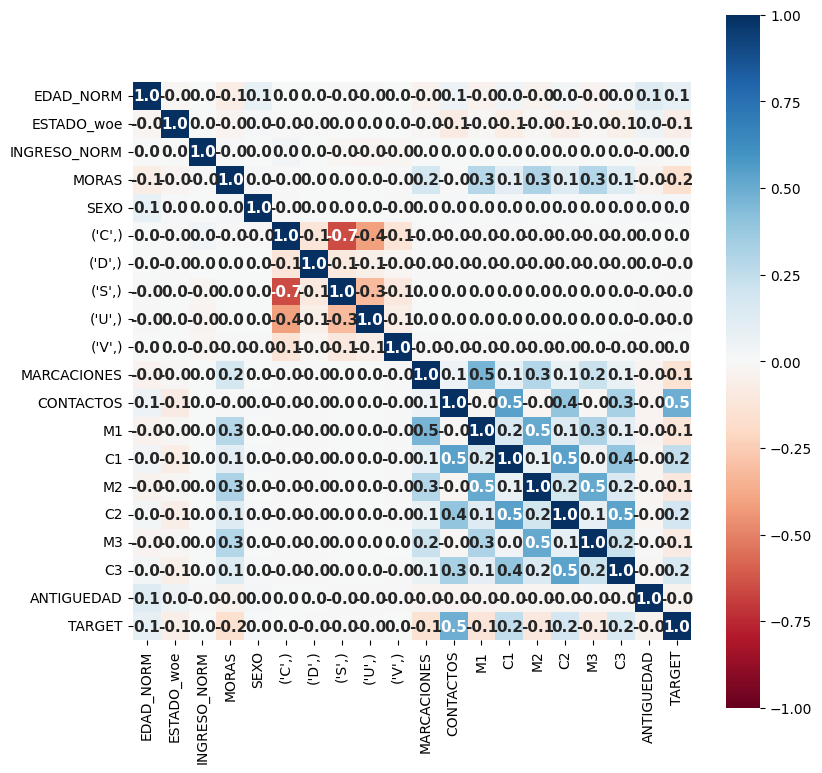

In [17]:
revision.grafica_correlacion()

0    6898572
1    2367854
Name: TARGET, dtype: int64


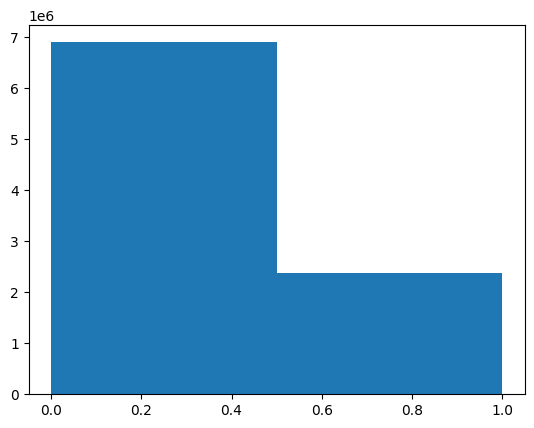

In [24]:
# Revision desbalanceo en Target
print(revision.df['TARGET'].value_counts())
plt.hist(revision.df['TARGET'], bins=2)
plt.show()

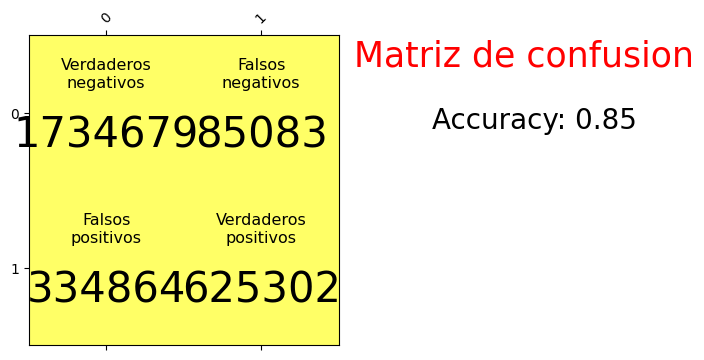

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def ajsute_desbalace_LogReg(target):
    # Implementacion de ajuste en caso de desbalanceo de clases para 
    # implementacion en LogisticRegression
    conteo = target.value_counts() 
    numero_clases = 2
    val_TARGET_0 = conteo.index[0]
    val_TARGET_1 = conteo.index[1]
    cant_TARGET_0 = conteo[0]
    cant_TARGET_1 = conteo[1]
    total = cant_TARGET_0 + cant_TARGET_1
    peso_TARGET_0 = total/(numero_clases*cant_TARGET_0)
    peso_TARGET_1 = total/(numero_clases*cant_TARGET_1)
    return { val_TARGET_0 : peso_TARGET_0, val_TARGET_1 : peso_TARGET_1   }

# Variables recomendadas con un nivel de correlacion inter variable de 0.3: 
variables = ['CONTACTOS', 'MORAS', 'MARCACIONES']
df_modelado = revision.df[variables]

# Division en datos de entrenamiento y datos de prueba 
X_train, X_test, y_train, y_test = train_test_split(revision.df[variables], revision.df['TARGET'] , test_size=0.3, random_state=42)

# creacion del modelo 
modelo = LogisticRegression(class_weight = ajsute_desbalace_LogReg(revision.df['TARGET'])).fit(X_train, y_train)

# Prediciones para evaluar modelo
y_test_predictions = modelo.predict(X_test) 

def grafica_confusion_matrix(y_test, y_test_predictions,modelo):
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=modelo.classes_)
    ax.set(title='Confusion Matrix')
    display.plot(ax=ax)


def matriz_de_confusion(clases_reales, clases_predichas, titulo):
    """ Visualiza la matriz de confusión """
   
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)
    
    #Código de matplotlib para graficar 
    plt.figure(figsize=(4, 4))
    matriz = pd.DataFrame(matriz, columns=["0", "1"])
    plt.matshow(matriz, cmap="summer", vmin=0, vmax=20, fignum=1)
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.show()

matriz_de_confusion(y_test, y_test_predictions, "Matriz de confusion")
#grafica_confusion_matrix(y_test, y_test_predictions,modelo)

In [ ]:

# Regresion logistica es el clasificador binario en su formato mas simple

In [39]:
revision.df['TARGET'].value_counts()[0], revision.df['TARGET'].value_counts()[1]

(6898572, 2367854)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 

def matriz_de_confusion(clases_reales, clases_predichas, titulo):
    """ Visualiza la matriz de confusión """
   
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)
    
    #Código de matplotlib para graficar 
    plt.figure(figsize=(4, 4))
    matriz = pd.DataFrame(matriz, 
                          columns=["0", "1"])
    plt.matshow(matriz, cmap="summer", vmin=0, vmax=20, fignum=1)
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")           
    plt.show()

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split




['EDAD_NORM', 'C2']

<Axes: xlabel='CONTACTOS', ylabel='MORAS'>

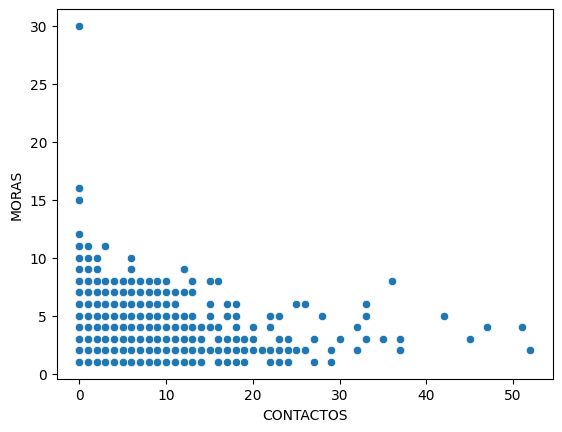

In [44]:
df_to_plot = revision.df.sample(10000)

sns.scatterplot(data=df_to_plot , x='CONTACTOS', y='MORAS')

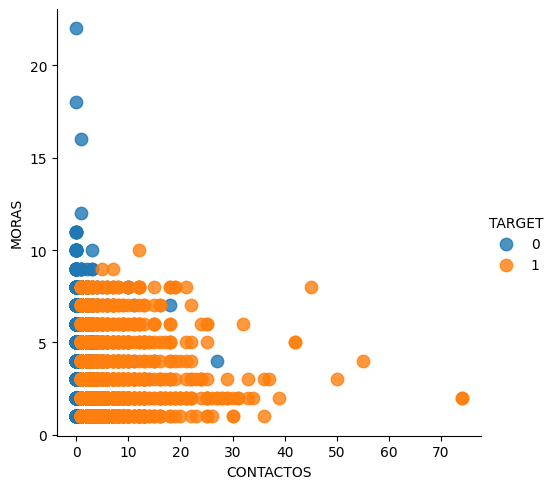

In [42]:
# vars_to_plot = revision.df.iloc[:,:-1].sample(2, axis=1).columns.tolist()
vars_to_plot = ['CONTACTOS', 'MORAS']

df_to_plot = revision.df.sample(10000)
sns.lmplot(x = vars_to_plot[0] , y  = vars_to_plot[1] , data = df_to_plot , fit_reg = False, hue = 'TARGET', legend = True, scatter_kws = {"s":80})

In [ ]:
# df_prueba_MANANA = revision.df.sample(100000)   #.to_csv(f"{self.file_path[:-4]}_ValoresPerdidos.csv ", index=False)
# df_prueba_MANANA.reset_index(inplace=True,drop=True)
# df_prueba_MANANA.to_csv("df_prueba_MANANA.csv ", index=False)

In [ ]:

data_set = revision.df.sample(10000)
print(dataset.groupby('SEXO').INGRESO.mean())